[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/opt/anaconda3/envs/deeplearning-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016 - val_loss: 0.0071
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0091
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0111
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0087
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0138
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6285e-04 - val_loss: 0.0048
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5123e-04 - val_loss: 0.0058
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3882e-04 - val_loss: 0.0079
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

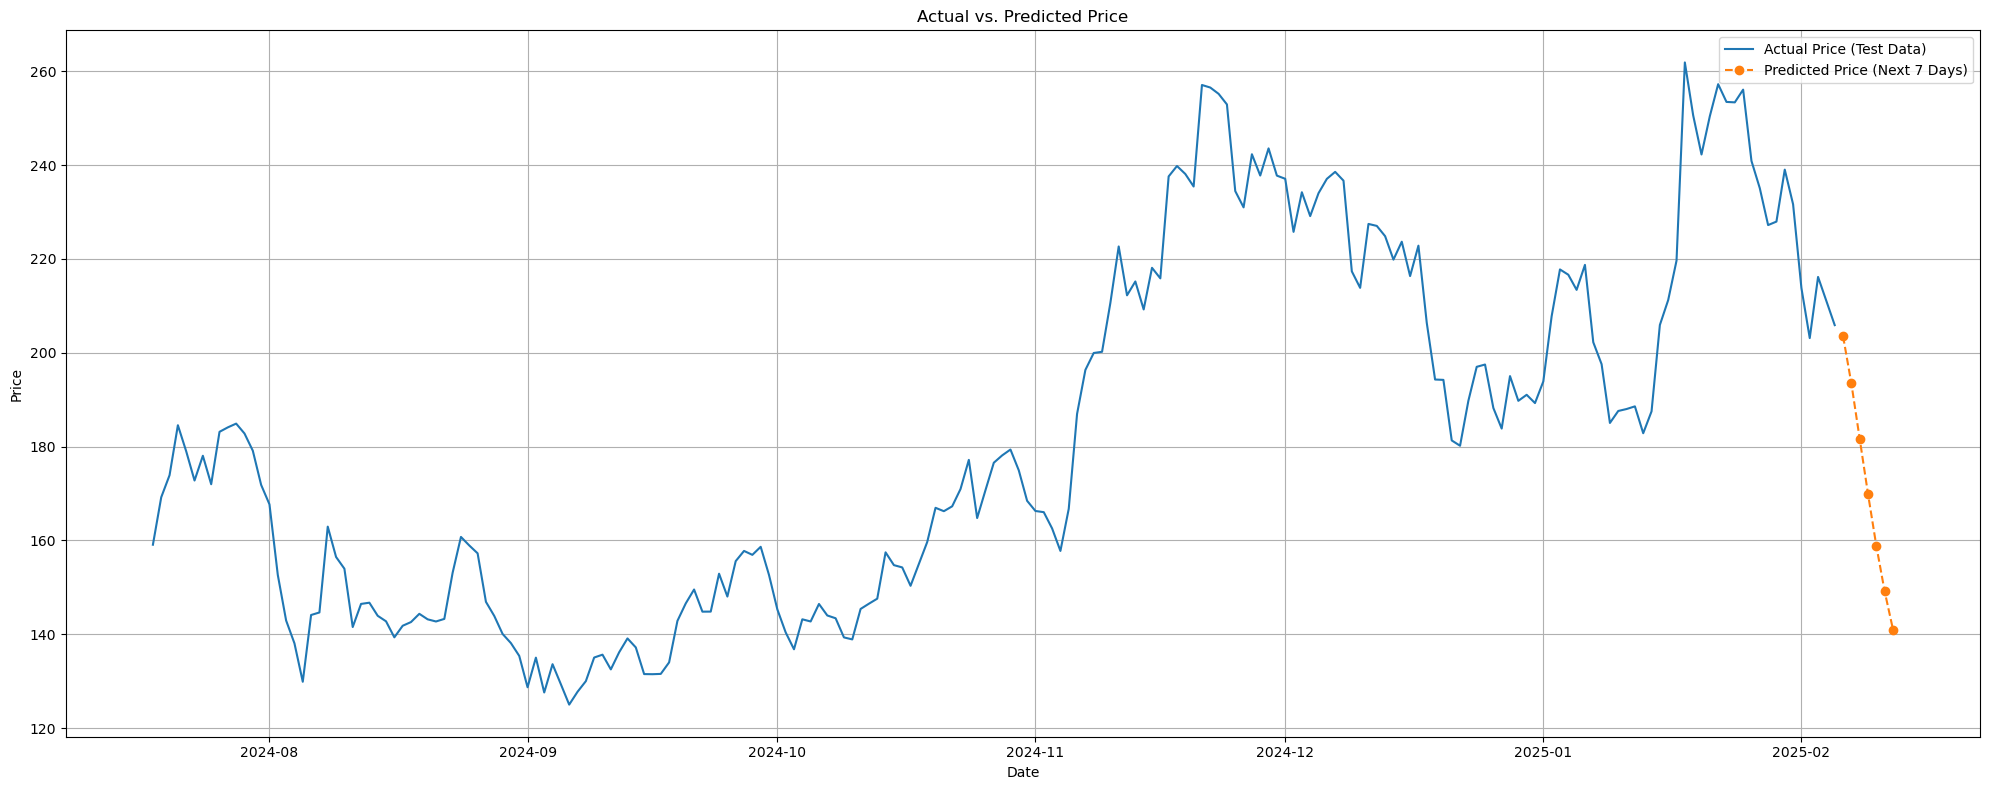

Predicted Price for 2025-02-06 00:00:00: 203.55357937073333
Predicted Price for 2025-02-07 00:00:00: 193.44400396560852
Predicted Price for 2025-02-08 00:00:00: 181.65390911259666
Predicted Price for 2025-02-09 00:00:00: 169.87839662110102
Predicted Price for 2025-02-10 00:00:00: 158.8162773083579
Predicted Price for 2025-02-11 00:00:00: 149.1181199317011
Predicted Price for 2025-02-12 00:00:00: 141.0005101430522


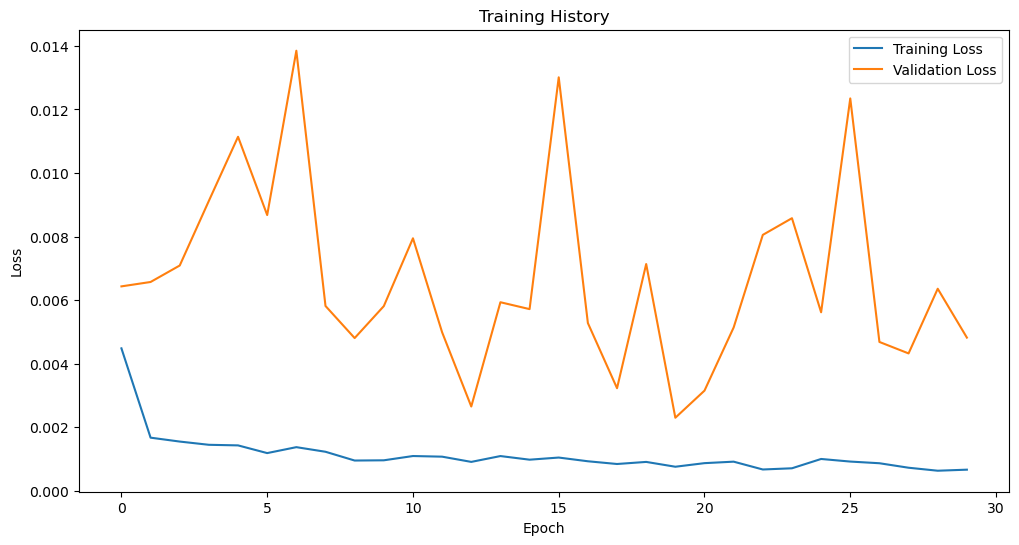

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Data Loading and Feature Engineering
data = yf.download('SOL-USD', start='2022-01-01')

data['EMA'] = data['Close'].ewm(span=7, adjust=False).mean()
data['STD'] = data['Close'].rolling(window=7).std()
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA21'] = data['Close'].rolling(window=21).mean()
data = data.dropna()

features = ['Close', 'EMA', 'STD', 'MA7', 'MA21']
dataset = data[features].values

# Scaling (Important: Scale before train/test split)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Train-Test Split
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False) # Keep order for time series

# Dataset Creation
look_back = 21
def create_dataset(data, look_back=7):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        y.append(data[i, 0])  # Target is 'Close'
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, look_back=look_back)
X_test, y_test = create_dataset(test_data, look_back=look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# Improved Model Building
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Prediction and Evaluation on Test Set
y_pred_scaled = model.predict(X_test)

# Dummy array for y_pred (same as before)
dummy_array_pred = np.zeros((y_pred_scaled.shape[0], dataset.shape[1]))
dummy_array_pred[:, 0] = y_pred_scaled[:, 0]
y_pred = scaler.inverse_transform(dummy_array_pred)[:, 0]

# ***Corrected inverse transform for y_test***
dummy_array_test = np.zeros((y_test.shape[0], dataset.shape[1]))  # Create dummy array for y_test
dummy_array_test[:, 0] = y_test  # Fill with the 'Close' values
y_test_original = scaler.inverse_transform(dummy_array_test)[:, 0]  # Inverse transform and extract 'Close'

mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R^2): {r2}")


# Future Prediction
n_predictions = 7
predictions = []
last_lookback_days = scaled_data[-look_back:]

for i in range(n_predictions):
    X_pred = np.array([last_lookback_days])
    X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], X_pred.shape[2]))
    predicted_data_scaled = model.predict(X_pred)

    # ***Corrected inverse transform for future predictions***
    dummy_array_future = np.zeros((predicted_data_scaled.shape[0], dataset.shape[1]))  # Create dummy array
    dummy_array_future[:, 0] = predicted_data_scaled[:, 0]  # Fill with the prediction
    predicted_price = scaler.inverse_transform(dummy_array_future)[0, 0]  # Inverse transform and extract

    predictions.append(predicted_price)

    # Update the scaled data for the next prediction (using the *predicted* value)
    dummy_row_scaled = np.zeros((1, scaled_data.shape[1]))
    dummy_row_scaled[0, 0] = predicted_data_scaled[0, 0]  # Use the scaled prediction
    scaled_data = np.concatenate((scaled_data, dummy_row_scaled), axis=0)
    last_lookback_days = scaled_data[-look_back:] # Update last_lookback_days


# Plotting (Improved)
plt.figure(figsize=(20, 8))

# Plot actual values (full range or last part)
plt.plot(data.index[-len(y_test_original):], y_test_original, label='Actual Price (Test Data)')  # Plot against test data indices

# Plot predictions
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_predictions)
plt.plot(future_dates, predictions, label='Predicted Price (Next 7 Days)', marker='o', linestyle='--')


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for i in range(n_predictions):
    print(f"Predicted Price for {future_dates[i]}: {predictions[i]}")

#Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()

In [14]:
model.save("sol_price_prediction_model.h5")

In [15]:
import pickle  # For serializing Python objects

with open("sol_price_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
